# Setting up Colab environment

In [ ]:
import os
username = 'SkoltechAI'
repo = 'Recommender-Systems-Intro-Sber-2022'

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{username}/{repo}.git

In [ ]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset, DataLoader

from polara import get_movielens_data
from polara.preprocessing.dataframes import reindex, leave_one_out

# navigating to cloned repo directory in Colab
%cd {repo} 
from dataprep import transform_indices
%cd -

# Preparing data

In [2]:
mldata = get_movielens_data(include_time=True)

In [3]:
test_timepoint = mldata['timestamp'].quantile(
    q=0.95, interpolation='nearest'
)

In [4]:
test_data_ = mldata.query('timestamp >= @test_timepoint')

In [5]:
test_data_.nunique()

userid         813
movieid       3249
rating           5
timestamp    33729
dtype: int64

In [6]:
train_data_ = mldata.query(
    'userid not in @test_data_.userid.unique() and timestamp < @test_timepoint'
)

In [7]:
training, data_index = transform_indices(train_data_.copy(), 'userid', 'movieid')

In [8]:
test_data = reindex(test_data_, data_index['items'])

Filtered 64 invalid observations.


In [9]:
test_data.nunique()

userid         813
movieid       3220
rating           5
timestamp    33678
dtype: int64

We sample the last item for each test user.  
As all these users are excluded from the training, and training is additionally filtered by timestamp,
there will be no "recommendation from future" issue - our model is unaware of future correlations.


In [10]:
testset_, holdout_ = leave_one_out(
    test_data, target='timestamp', sample_top=True, random_state=0
)
testset_valid_, holdout_valid_ = leave_one_out(
    testset_, target='timestamp', sample_top=True, random_state=0
)

Let's focus on validation part.

In [11]:
userid = data_index['users'].name
test_users = pd.Index(
    np.intersect1d(
        testset_valid_[userid].unique(),
        holdout_valid_[userid].unique()
    )
)
testset_valid = (
    testset_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)
holdout_valid = (
    holdout_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)

In [12]:
testset_valid.nunique()

userid         750
movieid       3202
rating           5
timestamp    32400
dtype: int64

In [13]:
holdout_valid.shape

(750, 4)

In [14]:
assert holdout_valid.set_index('userid')['timestamp'].ge(
    testset_valid
    .groupby('userid')
    ['timestamp'].max()
).all()

In [15]:
train_sessions = (
    training
    .sort_values(['userid', 'timestamp'])
    .groupby('userid')
    ['movieid']
    .apply(list)
)

In [16]:
print(train_sessions[1])

[1088, 1100, 1107, 2472, 1181, 2693, 1115, 1084, 308, 2774, 2610, 1103, 1734, 1097, 573, 2836, 3186, 1663, 498, 1000, 2271, 2779, 106, 1854, 2888, 1135, 2846, 1239, 1086, 1746, 1742, 841, 1627, 994, 1751, 3189, 3362, 3442, 1147, 1743, 1591, 2483, 1757, 1013, 823, 3171, 3291, 2604, 3060, 2810, 257, 2084, 570, 1141, 2813, 1132, 3407, 1744, 1133, 2011, 3386, 902, 1981, 2043, 1314, 2986, 619, 227, 1006, 1029, 481, 1134, 3593, 1390, 1079, 2167, 2130, 2092, 345, 2849, 1153, 3513, 569, 1817, 2336, 440, 2666, 1453, 463, 156, 369, 3138, 2987, 1284, 20, 338, 1382, 2124, 1795, 2051, 1249, 620, 2198, 1596, 1251, 1403, 2260, 1264, 723, 2633, 2848, 357, 1603, 158, 442, 425, 1441, 2386, 1526, 2988, 690, 1791, 1913, 282, 92, 1523, 417, 1396, 1707]


In [17]:
valid_sessions = (
    testset_valid
    .sort_values(['userid', 'timestamp'])
    .groupby('userid')
    ['movieid']
    .apply(list)
    .combine(
        holdout_valid
        .groupby('userid')
        ['movieid']
        .apply(list),
        lambda x,y: x+y
    )
)

In [18]:
# check that holdout item is at the last position
assert (valid_sessions.str[-1] == holdout_valid.set_index('userid').movieid).all()

# Data loader

In [65]:
class GRUDataset(Dataset):
    def __init__(self, session_data, max_length, pad_token, mode='train'):
        self.max_length = max_length
        self.pad_token = pad_token
        self.mode = mode
        self.session_data = self.process_sessions(session_data)
        self.all_sessions = sorted(self.session_data.keys())
    
    def process_sessions(self, session_data):
        sessions = (
            session_data
            # do not allow sequences with a single item
            .loc[lambda x: x.apply(len)>1]
            .reset_index(drop=True)
            # take only the most recent items if sequence is too long
            .str[-self.max_length:]
        )
        return sessions 

    def __len__(self):
        return len(self.all_sessions)

    def __getitem__(self, index):
        session_id = self.all_sessions[index]
        session = self.session_data[session_id]
        
        # create fixed-length representation of session
        seen_items = np.full(self.max_length, self.pad_token)
        n_seen_items = len(session) - 1
        seen_items[:n_seen_items] = session[:-1]

        if self.mode == 'train':
            next_items = np.full(self.max_length, self.pad_token)
            next_items[:n_seen_items] = session[1:]
        if self.mode == 'eval':
            next_items = session[-1:]
        
        return (
            torch.cuda.LongTensor(seen_items),
            torch.cuda.LongTensor(next_items),
            n_seen_items,
            session_id
        )

In [66]:
max_length = 200
pad_token = len(data_index['items'])
train_dataset = GRUDataset(train_sessions, max_length, pad_token, mode='train')

In [67]:
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False)

In [78]:
class GRU4Rec(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, pad_token):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.pad_token = pad_token
        self._batch_first = True
        
        self.item_embedding = nn.Embedding(output_dim+1, embedding_dim, padding_idx=pad_token)
        self.gru_layer = nn.GRU(embedding_dim, self.hidden_dim, batch_first=self._batch_first)
        self.output_layer = nn.Linear(hidden_dim, output_dim+1)
    
    def forward(self, seen_items, session_length):
        # embedding layer
        item_embedding = self.item_embedding(seen_items)
        item_embedding_packed = pack_padded_sequence(
            item_embedding,
            session_length,
            batch_first = self._batch_first,
            enforce_sorted = False
        ).cuda()
        # GRU layer
        # default starting hidden state is all 0 - works for our case!
        states_packed, final_state = self.gru_layer(item_embedding_packed)
        
        # output layer 
        if self.training: # sequential next item prediction
            outputs = self.output_layer(states_packed.data)
        else: # session continuation with next item
            outputs = self.output_layer(final_state)
        return outputs

In [79]:
model = GRU4Rec(
    64, 16, len(data_index['items']), train_dataset.pad_token
).cuda()

In [80]:
criterion = torch.nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-3
)

In [81]:
def train(loader, model, optimizer, criterion):
    model.train()
    losses = []

    for batch, targets, sizes, sessid in loader:
        sizes = sizes.squeeze()
        optimizer.zero_grad()
        loss = criterion(model(batch, sizes), pack_targets(targets, sizes))
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().item())        
    
    return losses

def pack_targets(targets, sizes):
    packed = pack_padded_sequence(
            targets,
            sizes,
            batch_first = True,
            enforce_sorted = False
        ).cuda()
    return packed.data

In [82]:
losses = []
for epoch in tqdm(range(100)):
    losses.extend(train(train_dl, model, optimizer, criterion))

100%|██████████| 100/100 [05:56<00:00,  3.57s/it]


<AxesSubplot:>

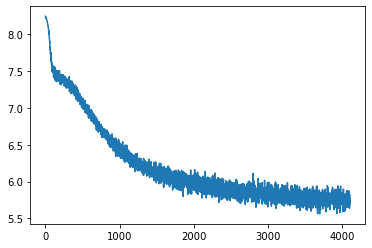

In [83]:
pd.Series(losses).plot()

## Validation

In [84]:
valid_dataset = GRUDataset(valid_sessions, max_length, pad_token, mode='eval')
valid_dl = DataLoader(valid_dataset, batch_size=128, shuffle=False, drop_last=False)

In [85]:
hits = []
model.eval()
with torch.no_grad():
    for batch, targets, sizes, sessid in valid_dl:
        sizes = sizes.squeeze()
        outputs = model(batch, sizes).squeeze()
        _, inds = torch.topk(outputs, 10)
        _, hits_index = torch.where(inds == targets)
        if len(hits_index):
            hits.append(hits_index)

In [86]:
print(f'HR={torch.concat(hits).size(0) / len(valid_dl.dataset):.4f}')

HR=0.0653


In [87]:
print(f'MRR={sum([1./(r+1).item() for h in hits for r in h]) / len(valid_dl.dataset):.4f}')

MRR=0.0191
